In [1]:
%pylab inline
import pysal as ps



Populating the interactive namespace from numpy and matplotlib


In [2]:
ntw = ps.Network(ps.examples.get_path('geodanet/streets.shp'))

#Snap a point pattern to the network
ntw.snapobservations(ps.examples.get_path('geodanet/crimes.shp'), 'crimes', attribute=True)
ntw.snapobservations(ps.examples.get_path('geodanet/schools.shp'), 'schools', attribute=False)

####A network is composed of a single topological representation of a road and $n$ point patterns which are snapped to the network.

In [3]:
ntw.pointpatterns

{'crimes': <pysal.network.network.PointPattern instance at 0x107fb1710>,
 'schools': <pysal.network.network.PointPattern instance at 0x107fc1b90>}

In [4]:
dir(ntw.pointpatterns['crimes'])

['__doc__',
 '__init__',
 '__module__',
 'dist_to_node',
 'npoints',
 'obs_to_edge',
 'obs_to_node',
 'points',
 'snapped_coordinates']

#####Attributes for every point pattern

1. dist_to_node dict keyed by pointid with the value being a dict in the form {node: distance to node, node: distance to node}
2. obs_to_edge dict keyed by edge with the value being a dict in the form {pointID:(x-coord, y-coord), pointID:(x-coord, y-coord), ... }
3. obs_to_node
4. points geojson like representation of the point pattern.  Includes properties if read with attributes=True
5. snapped_coordinates dict keyed by pointid with the value being (x-coord, y-coord)

####Counts per edge are important, but should not be precomputed since we have different representations of the network (digitized and graph currently).  (Relatively) Uniform segmentation still needs to be done.

In [5]:
counts = ntw.count_per_edge(ntw.pointpatterns['crimes'].obs_to_edge,
                            graph=False)
sum(counts.values()) / float(len(counts.keys()))

2.6822429906542058

### Segmentation

In [6]:
n200 = ntw.segment_edges(200.0)

In [7]:
counts = n200.count_per_edge(n200.pointpatterns['crimes'].obs_to_edge, graph=False)
sum(counts.values()) / float(len(counts.keys()))

2.0354609929078014

#### Visualization of the shapefile derived, unsegmented network with nodes in a larger, semi-opaque form and the distance segmented network with small, fully opaque nodes.

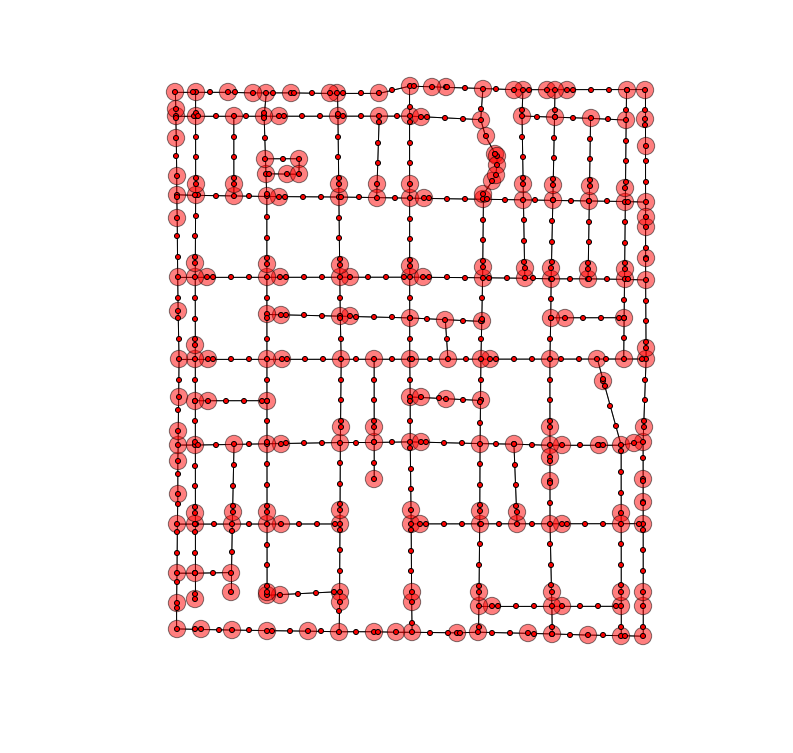

In [8]:
import networkx as nx
figsize(10,10)

g = nx.Graph()
for e in ntw.edges:
    g.add_edge(*e)
for n, p in ntw.node_coords.iteritems():
    g.node[n] = p
nx.draw(g, ntw.node_coords, node_size=300, alpha=0.5)

g = nx.Graph()
for e in n200.edges:
    g.add_edge(*e)
for n, p in n200.node_coords.iteritems():
    g.node[n] = p
nx.draw(g, n200.node_coords, node_size=25, alpha=1.0)

#####Moran's I using the digitized network

In [9]:
#Binary Adjacency
#ntw.contiguityweights(graph=False)

w = ntw.contiguityweights(graph=False)


#Build the y vector
#edges = ntw.w.neighbors.keys()
edges = w.neighbors.keys()
y = np.zeros(len(edges))
for i, e in enumerate(edges):
    if e in counts.keys():
        y[i] = counts[e]

#Moran's I
#res = ps.esda.moran.Moran(y, ntw.w, permutations=99)
res = ps.esda.moran.Moran(y, w, permutations=99)
print dir(res)

['EI', 'EI_sim', 'I', 'VI_norm', 'VI_rand', 'VI_sim', '_Moran__calc', '_Moran__moments', '__doc__', '__init__', '__module__', 'n', 'p_norm', 'p_rand', 'p_sim', 'p_z_sim', 'permutations', 'seI_norm', 'seI_rand', 'seI_sim', 'sim', 'w', 'y', 'z', 'z2ss', 'z_norm', 'z_rand', 'z_sim']


####Moran's I using the graph representation to generate the W

Note that we have to regenerate the counts per edge, since the graph will have less edges.

In [10]:
counts = ntw.count_per_edge(ntw.pointpatterns['crimes'].obs_to_edge, graph=True)

#Binary Adjacency
#ntw.contiguityweights(graph=True)
w = ntw.contiguityweights(graph=True)
#Build the y vector
#edges = ntw.w.neighbors.keys()
edges = w.neighbors.keys()
y = np.zeros(len(edges))
for i, e in enumerate(edges):
    if e in counts.keys():
        y[i] = counts[e]

#Moran's I
#res = ps.esda.moran.Moran(y, ntw.w, permutations=99)
res = ps.esda.moran.Moran(y, w, permutations=99)


print dir(res)

['EI', 'EI_sim', 'I', 'VI_norm', 'VI_rand', 'VI_sim', '_Moran__calc', '_Moran__moments', '__doc__', '__init__', '__module__', 'n', 'p_norm', 'p_rand', 'p_sim', 'p_z_sim', 'permutations', 'seI_norm', 'seI_rand', 'seI_sim', 'sim', 'w', 'y', 'z', 'z2ss', 'z_norm', 'z_rand', 'z_sim']


#### Moran's I using the segmented network and intensities instead of counts

In [11]:
#Binary Adjacency
#n200.contiguityweights(graph=False)
w = n200.contiguityweights(graph=False)


#Compute the counts
counts = n200.count_per_edge(n200.pointpatterns['crimes'].obs_to_edge, graph=False)

#Build the y vector and convert from raw counts to intensities
#edges = n200.w.neighbors.keys()
edges = w.neighbors.keys()
y = np.zeros(len(edges))
for i, e in enumerate(edges):
    if e in counts.keys():
        length = n200.edge_lengths[e]
        y[i] = counts[e] / length
      
#Moran's I
#res = ps.esda.moran.Moran(y, n200.w, permutations=99)
res = ps.esda.moran.Moran(y, w, permutations=99)


print dir(res)

['EI', 'EI_sim', 'I', 'VI_norm', 'VI_rand', 'VI_sim', '_Moran__calc', '_Moran__moments', '__doc__', '__init__', '__module__', 'n', 'p_norm', 'p_rand', 'p_sim', 'p_z_sim', 'permutations', 'seI_norm', 'seI_rand', 'seI_sim', 'sim', 'w', 'y', 'z', 'z2ss', 'z_norm', 'z_rand', 'z_sim']


### Timings for distance based methods, e.g. G-function

In [12]:
import time
t1 = time.time()
n0 = ntw.allneighbordistances(ntw.pointpatterns['crimes'])
print time.time()-t1

1.19567084312


In [13]:
import time
t1 = time.time()
n1 = n200.allneighbordistances(n200.pointpatterns['crimes'])
print time.time()-t1

11.2402291298


Note that the first time these methods are called, the underlying node-to-node shortest path distance matrix has to be calculated. Subsequent calls will not require this, and will be much faster:

In [14]:
import time
t1 = time.time()
n0 = ntw.allneighbordistances(ntw.pointpatterns['crimes'])
print time.time()-t1

0.136250972748


In [15]:
import time
t1 = time.time()
n1 = n200.allneighbordistances(n200.pointpatterns['crimes'])
print time.time()-t1

0.160092830658


####Simulate a point pattern on the network

Need to supply a count of the number of points and a distirbution (default is uniform).  Generally this will not be called by the user, since the simulation will be used for Monte Carlo permutation.

In [16]:
npts = ntw.pointpatterns['crimes'].npoints
sim = ntw.simulate_observations(npts)
sim

<pysal.network.network.SimulatedPointPattern instance at 0x1208e2878>

####Create a nearest neighbor matrix using the crimes point pattern

Right now, both the G and K functions generate a full distance matrix.  This is because, I know that the full generation is correct and I believe that the truncated generated, e.g. nearest neighbor, has a big.

### G-function

In [18]:
gres = ps.NetworkG(ntw,
                         ntw.pointpatterns['crimes'],
                         permutations = 99)

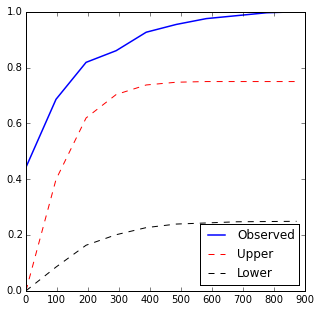

In [19]:
figsize(5,5)
plot(gres.xaxis, gres.observed, 'b-', linewidth=1.5, label='Observed')
plot(gres.xaxis, gres.upperenvelope, 'r--', label='Upper')
plot(gres.xaxis, gres.lowerenvelope, 'k--', label='Lower')
legend(loc='best')

###K-function

In [20]:
kres = ps.NetworkK(ntw,
                         ntw.pointpatterns['crimes'],
                         permutations=99)

/Users/serge/Dropbox/p/pysal/src/pysal/pysal/network/analysis.py:142: RuntimeWarning: invalid value encountered in less_equal
  y[i] = len(nearest[nearest <= s])


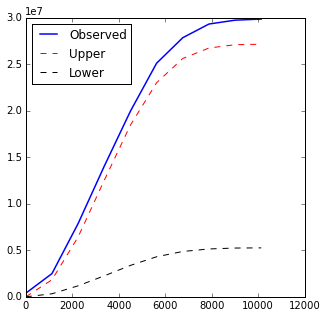

In [21]:
figsize(5,5)
plot(kres.xaxis, kres.observed, 'b-', linewidth=1.5, label='Observed')
plot(kres.xaxis, kres.upperenvelope, 'r--', label='Upper')
plot(kres.xaxis, kres.lowerenvelope, 'k--', label='Lower')
legend(loc='best')